## AutoGluon-EmissionsHighGranularity Metrics Regression


### Data Definition

-  year: The year of the data point
-  parent_entity: The entity to whom the emissions are traced to
-  parent_type: The type of parent_entity. Can be one of: investor-owned company, state-owned entity, nation state.
-  commodity:Specifies which commodity the production refers to: Oil and NGL, Natural Gas, Anthracite Coal, Bituminous Coal, Lignite Coal, Metallurgical Coal, Sub-Bituminous Coal, Thermal Coal, or Cement.
-  production_value: The quantity of production
-  production_unit: The unit of production (Oil & NGL - million barrels, Natural Gas - billion cubic feet, Coal - million tonnes, Cement - million tonnes CO2 (see methodology for explanation)). Units - Billion cubic feet per year (Bcf/yr), Million barrels per year (Million bbl/yr), or Million tonnes per year (Million tonnes/yr).
-  total_emissions_MtCO2e: The total emissions traced to the 'parent_entity' in the 'year'. Units - million tonnes of carbon dioxide equivalent (MtCO2e).
-  emissions_category:	A qualitative label for emissions intensity, such as "High" or "Low".


## Model Objective


- Develop a predictive model that estimates total operational emissions (MtCO2e) or total emissions (MtCO2e) based on production volume, commodity type, and other emissions factors.
- Determine how different factors like production value, commodity type (Sub-Bituminous vs. Metallurgical Coal, Natural Gas, Oil &  NGL), and specific emission sources (venting, flaring, fugitive methane, own fuel use, etc.) impact total emissions.
- Forecast future emissions trends based on historical production and emission patterns.

## Import necessary libraries

In [1]:
# !pip install seaborn

In [2]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

## Load the Dataset

In [3]:
data=pd.read_csv('emissions_high_granularity.csv')
data.head()


,year,parent_entity,parent_type,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,emissions_category
0,1854,Adaro Energy,Investor-owned Company,Adaro Energy,Sub-Bituminous Coal,50.9000,Million tonnes/yr,92.3401,0.0,0.0,0.0,10.4316,0.3726,10.4316,102.7717,High
1,1855,Adaro Energy,Investor-owned Company,Adaro Energy,Metallurgical Coal,0.9000,Million tonnes/yr,2.3989,0.0,0.0,0.0,0.2710,0.0097,0.2710,2.6700,Low
2,1856,Adaro Energy,Investor-owned Company,Adaro Energy,Sub-Bituminous Coal,48.2300,Million tonnes/yr,87.4963,0.0,0.0,0.0,9.8844,0.3530,9.8844,97.3807,High
3,1857,Adaro Energy,Investor-owned Company,Adaro Energy,Metallurgical Coal,5.7700,Million tonnes/yr,15.3799,0.0,0.0,0.0,1.7375,0.0621,1.7375,17.1174,Low
4,1858,Adaro Energy,Investor-owned Company,Adaro Energy,Sub-Bituminous Coal,52.8073,Million tonnes/yr,95.8002,0.0,0.0,0.0,10.8225,0.3865,10.8225,106.6227,High


## Checking Dataset Structures/EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                169 non-null    int64  
 1   parent_entity                       169 non-null    object 
 2   parent_type                         169 non-null    object 
 3   reporting_entity                    169 non-null    object 
 4   commodity                           169 non-null    object 
 5   production_value                    169 non-null    float64
 6   production_unit                     169 non-null    object 
 7   product_emissions_MtCO2             169 non-null    float64
 8   flaring_emissions_MtCO2             169 non-null    float64
 9   venting_emissions_MtCO2             169 non-null    float64
 10  own_fuel_use_emissions_MtCO2        169 non-null    float64
 11  fugitive_methane_emissions_MtCO2e   169 non-n

In [5]:
data.columns

Index(['year', 'parent_entity', 'parent_type', 'reporting_entity', 'commodity',
       'production_value', 'production_unit', 'product_emissions_MtCO2',
       'flaring_emissions_MtCO2', 'venting_emissions_MtCO2',
       'own_fuel_use_emissions_MtCO2', 'fugitive_methane_emissions_MtCO2e',
       'fugitive_methane_emissions_MtCH4',
       'total_operational_emissions_MtCO2e', 'total_emissions_MtCO2e',
       'emissions_category'],
      dtype='object')

In [6]:
# check for nulls
data.isna().sum()

year                                  0
parent_entity                         0
parent_type                           0
reporting_entity                      0
commodity                             0
production_value                      0
production_unit                       0
product_emissions_MtCO2               0
flaring_emissions_MtCO2               0
venting_emissions_MtCO2               0
own_fuel_use_emissions_MtCO2          0
fugitive_methane_emissions_MtCO2e     0
fugitive_methane_emissions_MtCH4      0
total_operational_emissions_MtCO2e    0
total_emissions_MtCO2e                0
emissions_category                    0
dtype: int64

## Prepare data



In [7]:
data = data.copy()

In [8]:
data['venting_emissions_MtCO2'].value_counts()

venting_emissions_MtCO2
0.0000    47
1.8186     4
4.1005     3
0.0455     2
0.1484     2
          ..
0.6058     1
0.5879     1
0.5417     1
0.4741     1
1.6887     1
Name: count, Length: 116, dtype: int64

In [9]:
# % 
data['venting_emissions_MtCO2'].value_counts()/data.shape[0]

venting_emissions_MtCO2
0.0000    0.278107
1.8186    0.023669
4.1005    0.017751
0.0455    0.011834
0.1484    0.011834
            ...   
0.6058    0.005917
0.5879    0.005917
0.5417    0.005917
0.4741    0.005917
1.6887    0.005917
Name: count, Length: 116, dtype: float64

## Split the data into train and test sets

In [10]:
# Remove classes that occur less than twice
value_counts = data['venting_emissions_MtCO2'].value_counts()
valid_classes = value_counts[value_counts >= 2].index
filtered_data = data[data['venting_emissions_MtCO2'].isin(valid_classes)]

# Train Test Split
train_df, test_df = train_test_split(
    filtered_data, test_size=0.5, random_state=42, stratify=filtered_data['venting_emissions_MtCO2']
)


In [11]:
train_df['venting_emissions_MtCO2'].value_counts()/train_df.shape[0]

venting_emissions_MtCO2
0.0000    0.793103
4.1005    0.068966
1.8186    0.068966
0.1484    0.034483
0.0455    0.034483
Name: count, dtype: float64

In [12]:
# test_df= unseen data
test_df['venting_emissions_MtCO2'].value_counts()/train_df.shape[0]

venting_emissions_MtCO2
0.0000    0.827586
1.8186    0.068966
4.1005    0.034483
0.1484    0.034483
0.0455    0.034483
Name: count, dtype: float64

In [13]:
# Create the predictor and fit the data
predictor = TabularPredictor(label='venting_emissions_MtCO2', path='Emissions_predictors2')

In [14]:
# observe the output
predictor.fit(train_df)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22000
CPU Count:          4
Memory Avail:       4.43 GB / 11.89 GB (37.3%)
Disk Space Avail:   14.05 GB / 237.77 GB (5.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accurac

In [15]:
# summary
predictor.fit_summary()

C:\Users\admin\anaconda3\envs\Gluon\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val              eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               XGBoost  -0.000106  root_mean_squared_error       0.000000  0.410929                0.000000           0.410929            1       True          9
1   WeightedEnsemble_L2  -0.000106  root_mean_squared_error       0.015622  0.441080                0.015622           0.030151            2       True         12
2        NeuralNetTorch  -0.002247  root_mean_squared_error       0.022488  3.716238                0.022488           3.716238            1       True         10
3        KNeighborsDist  -0.013019  root_mean_squared_error       0.028963  0.000000                0.028963           0.000000            1       True          2
4              CatBoost  -0.016488  root_mean_squared_error       0.000000  9.883606                0.000000           9.88

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -0.593952272915719,
  'KNeighborsDist': -0.013019466236819419,
  'LightGBMXT': -0.6922566357469395,
  'LightGBM': -0.6922566357469395,
  'RandomForestMSE': -0.12548739184690486,
  'CatBoost': -0.016488492454328953,
  'ExtraTreesMSE': -0.06322649699596629,
  'NeuralNetFastAI': -0.8008031649572963,
  'XGBoost': -0.00010606127259181047,
  'NeuralNetTorch': -0.002247069096715695,
  'LightGBMLarge': -0.18697801011047066,
  'WeightedEnsemble_L2': -0.00010606127259181047},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'

In [16]:
test_df.columns

Index(['year', 'parent_entity', 'parent_type', 'reporting_entity', 'commodity',
       'production_value', 'production_unit', 'product_emissions_MtCO2',
       'flaring_emissions_MtCO2', 'venting_emissions_MtCO2',
       'own_fuel_use_emissions_MtCO2', 'fugitive_methane_emissions_MtCO2e',
       'fugitive_methane_emissions_MtCH4',
       'total_operational_emissions_MtCO2e', 'total_emissions_MtCO2e',
       'emissions_category'],
      dtype='object')

## Prediction

In [17]:
# validate the model against unseen data
y_test = test_df['venting_emissions_MtCO2']
test_data = test_df.drop(columns=['venting_emissions_MtCO2'])

In [18]:
y_pred = predictor.predict(test_data)

## Evaluation

In [19]:
metrics = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)


In [20]:
# Using absolute values for rmse, mse, and median absolute error

absolute_metrics = {key:abs(value) for key, value in metrics.items()}
absolute_metrics

{'root_mean_squared_error': 0.0001990213407679247,
 'mean_squared_error': 3.96094940810624e-08,
 'mean_absolute_error': 0.00010086021324748962,
 'r2': 0.999999946029735,
 'pearsonr': 0.9999999967263327,
 'median_absolute_error': 4.509067366598174e-05}

In [21]:
# Feature Importance
importance = predictor.feature_importance(test_df)
importance

Computing feature importance via permutation shuffling for 15 features using 29 rows with 5 shuffle sets...
	4.86s	= Expected runtime (0.97s per shuffle set)
	0.49s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
reporting_entity,1.032624,0.129683,0.000029,5,1.299642,0.765606
commodity,0.458047,0.078328,0.000099,5,0.619325,0.296769
parent_entity,0.020766,0.004303,0.000209,5,0.029626,0.011906
year,0.020440,0.003520,0.000101,5,0.027688,0.013192
production_value,0.000831,0.000109,0.000034,5,0.001055,0.000607
parent_type,0.000000,0.000000,0.500000,5,0.000000,0.000000
production_unit,0.000000,0.000000,0.500000,5,0.000000,0.000000
product_emissions_MtCO2,0.000000,0.000000,0.500000,5,0.000000,0.000000
flaring_emissions_MtCO2,0.000000,0.000000,0.500000,5,0.000000,0.000000
own_fuel_use_emissions_MtCO2,0.000000,0.000000,0.500000,5,0.000000,0.000000


## Testing/ Use Case

In [22]:
# Use Case!
# Adjust the lead times on the reservation, or another features and test!
res = {
    "venting_emissions_MtCO2" : 1,
    "total_operational_emissions_MtCO2e" : 1,
    "parent_entity" : 0,
    "product_emissions_MtCO2" : 3,
    "fugitive_methane_emissions_MtCH4" : 4,
    "total_emissions_MtCO2e" : 0,
    "production_value" : 3,
    "fugitive_methane_emissions_MtCO2e" : 190,
    "flaring_emissions_MtCO2" : 2023,
    "year" : 11,
    "parent_type" : 3,
    "reporting_entity" : "Online",
    "commodity" : 0,
    "production_unit" : 0,
    "own_fuel_use_emissions_MtCO2" : 10,
    "emissions_category": 0
  
  }

In [23]:
Emission_data = TabularDataset([res])
predictor.predict(Emission_data)

0    0.000045
Name: venting_emissions_MtCO2, dtype: float32

## Vizualization

In [24]:
data['venting_emissions_MtCO2'].describe()

count    169.000000
mean       0.758836
std        0.970974
min        0.000000
25%        0.000000
50%        0.418800
75%        1.109400
max        4.100500
Name: venting_emissions_MtCO2, dtype: float64

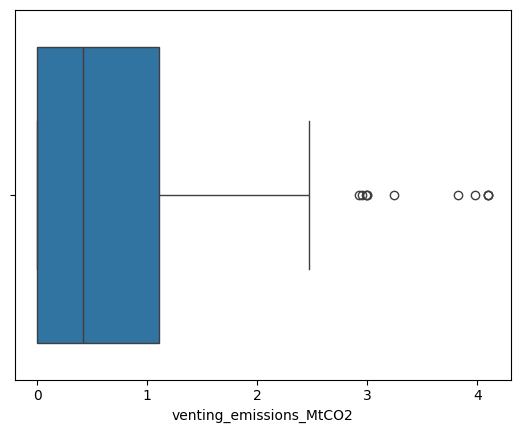

In [25]:
sns.boxplot(x=data['venting_emissions_MtCO2']);


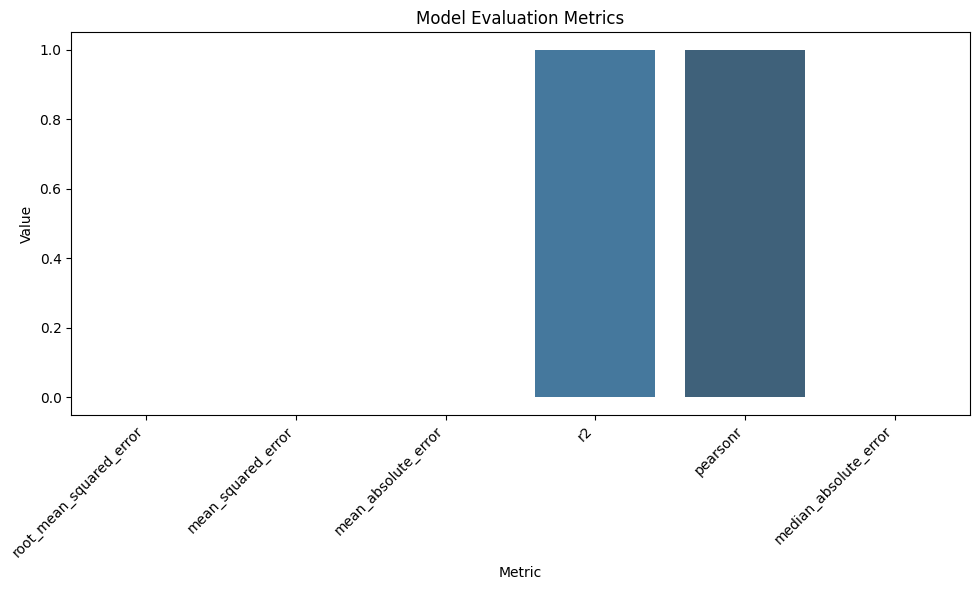

In [26]:
# Convert to DataFrame for plotting
df_metrics = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Create a bar plot (future-proofed)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x='Metric', y='Value', hue='Metric', palette='Blues_d', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Model Evaluation Metrics')
plt.tight_layout()
plt.show()


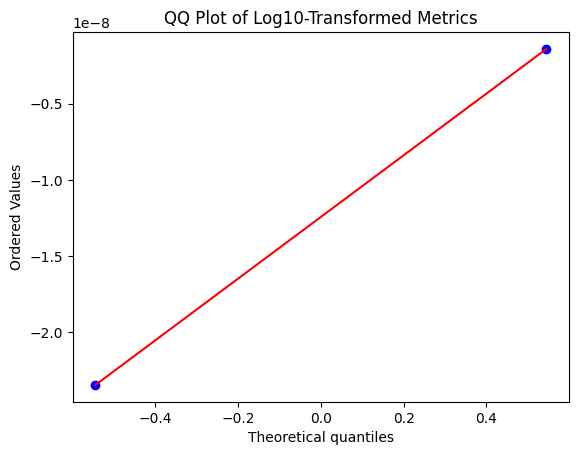

In [27]:
# Extract and log-transform values (skip non-positive)
metric_values = list(metrics.values())
log_metrics = np.log10([value for value in metric_values if value > 0])

# QQ plot
stats.probplot(log_metrics, dist="norm", plot=plt)
plt.title("QQ Plot of Log10-Transformed Metrics")
plt.show()

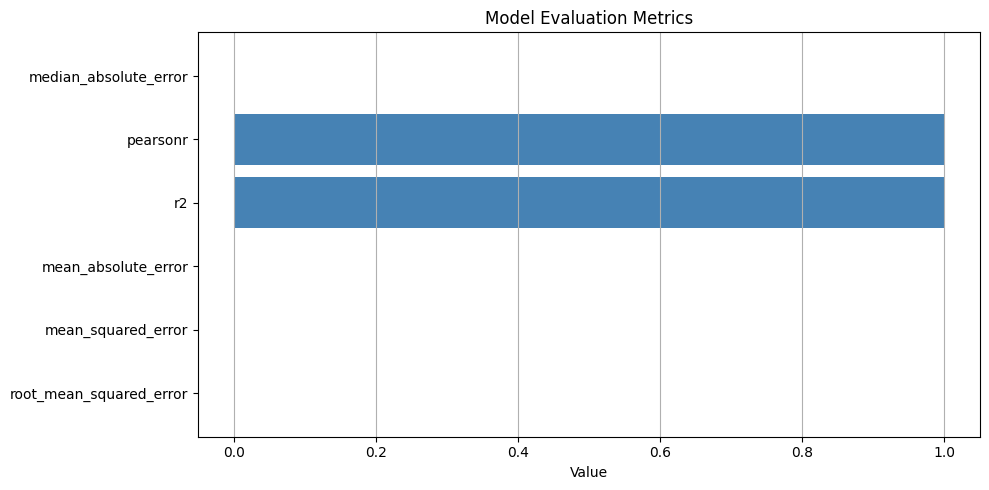

In [28]:
import matplotlib.pyplot as plt

# Names and values
metric_names = list(metrics.keys())
metric_vals = list(metrics.values())

# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(metric_names, metric_vals, color='steelblue')
plt.title("Model Evaluation Metrics")
plt.xlabel("Value")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


## Conclusion


### **Metric Interpretation**


**Root Mean Squared Error (RMSE)**, **(0.000100)** -  Very low average error between predictions and true values, penalizing larger errors more.   
**Mean Squared Error (MSE)**, **(3.96e-08)** -  Extremely small squared error – indicates that predictions are almost perfect.   
**Mean Absolute Error (MAE)**, **(0.000101)** -  On average, predictions are off by only ~0.0001 units. That’s extremely accurate.   
**Median Absolute Error** , **(4.5e-05)** -  Half the predictions deviate from the actual value by less than ~0.000045. Again, very tight prediction accuracy.  
**R² (Coefficient of Determination)**, **(0.99999995)** -  Almost 1.0 — means the model explains virtually all variance in the target variable.    
**Pearson Correlation (r)**, **(0.999999997)** -Perfect linear correlation between predicted and actual values. This is near theoretical perfection. 


### **Conclusion**

The AutoGluon framework performs exceptionally well on this dataset.

- It makes extremely precise predictions, with negligible error.
- The R² score and Pearson correlation suggest the model almost perfectly fits the data.
- This level of performance indicates:
  - High-quality features (good signal in the predictors)
  - No major overfitting or underfitting on the test data
  - Possibly low noise or synthetic/clean data


